In [1]:
import torch
from torch.autograd import Variable
import warnings
from torch import nn
from collections import OrderedDict
import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import data as data
from data.BehavioralDataset import BehavioralDataset
from data.BehavioralHmSamples import BehavioralHmSamples
import scipy
from sklearn.preprocessing import MinMaxScaler

In [2]:
warnings.filterwarnings("ignore")

In [3]:
def load_netG(path, isize, nz, nc, ngf, n_extra_layers):
    assert isize % 16 == 0, "isize has to be a multiple of 16"

    cngf, tisize = ngf//2, 4
    while tisize != isize:
        cngf = cngf * 2
        tisize = tisize * 2

    main = nn.Sequential()
    # input is Z, going into a convolution
    main.add_module('initial:{0}-{1}:convt'.format(nz, cngf),
                    nn.ConvTranspose2d(nz, cngf, 4, 1, 0, bias=False))
    main.add_module('initial:{0}:batchnorm'.format(cngf),
                    nn.BatchNorm2d(cngf))
    main.add_module('initial:{0}:relu'.format(cngf),
                    nn.ReLU(True))

    csize, cndf = 4, cngf
    while csize < isize//2:
        main.add_module('pyramid:{0}-{1}:convt'.format(cngf, cngf//2),
                        nn.ConvTranspose2d(cngf, cngf//2, 4, 2, 1, bias=False))
        main.add_module('pyramid:{0}:batchnorm'.format(cngf//2),
                        nn.BatchNorm2d(cngf//2))
        main.add_module('pyramid:{0}:relu'.format(cngf//2),
                        nn.ReLU(True))
        cngf = cngf // 2
        csize = csize * 2

    # Extra layers
    for t in range(n_extra_layers):
        main.add_module('extra-layers-{0}:{1}:conv'.format(t, cngf),
                        nn.Conv2d(cngf, cngf, 3, 1, 1, bias=False))
        main.add_module('extra-layers-{0}:{1}:batchnorm'.format(t, cngf),
                        nn.BatchNorm2d(cngf))
        main.add_module('extra-layers-{0}:{1}:relu'.format(t, cngf),
                        nn.ReLU(True))

    main.add_module('final:{0}-{1}:convt'.format(cngf, nc),
                    nn.ConvTranspose2d(cngf, nc, 4, 2, 1, bias=False))
    main.add_module('final:{0}:tanh'.format(nc),
                    nn.Tanh())
    
    state_dict = torch.load(path, map_location=torch.device('cpu'))

    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[5:] # remove `main.`
        new_state_dict[name] = v
    
    main.load_state_dict(new_state_dict, strict=False)
    
    return main

In [4]:
def load_netG_mlp(path, isize, nz, nc, ngf):
    
    main = nn.Sequential(
        # Z goes into a linear of size: ngf
        nn.Linear(nz, ngf),
        nn.ReLU(True),
        nn.Linear(ngf, ngf),
        nn.ReLU(True),
        nn.Linear(ngf, ngf),
        nn.ReLU(True),
        nn.Linear(ngf, nc * isize * isize),
    )
    
    state_dict = torch.load(path, map_location=torch.device('cpu'))

    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[5:] # remove `main.`
        new_state_dict[name] = v
    
    main.load_state_dict(new_state_dict, strict=False)
    
    return main

In [5]:

def load_netD(path, isize, nc, ndf, n_extra_layers):
    
    assert isize % 16 == 0, "isize has to be a multiple of 16"

    main = nn.Sequential()
    # input is nc x isize x isize
    main.add_module('initial:{0}-{1}:conv'.format(nc, ndf),
                    nn.Conv2d(nc, ndf, 4, 2, 1, bias=False))
    main.add_module('initial:{0}:relu'.format(ndf),
                    nn.LeakyReLU(0.2, inplace=True))
    csize, cndf = isize / 2, ndf

    # Extra layers
    for t in range(n_extra_layers):
        main.add_module('extra-layers-{0}:{1}:conv'.format(t, cndf),
                        nn.Conv2d(cndf, cndf, 3, 1, 1, bias=False))
        main.add_module('extra-layers-{0}:{1}:batchnorm'.format(t, cndf),
                        nn.BatchNorm2d(cndf))
        main.add_module('extra-layers-{0}:{1}:relu'.format(t, cndf),
                        nn.LeakyReLU(0.2, inplace=True))

    while csize > 4:
        in_feat = cndf
        out_feat = cndf * 2
        main.add_module('pyramid:{0}-{1}:conv'.format(in_feat, out_feat),
                        nn.Conv2d(in_feat, out_feat, 4, 2, 1, bias=False))
        main.add_module('pyramid:{0}:batchnorm'.format(out_feat),
                        nn.BatchNorm2d(out_feat))
        main.add_module('pyramid:{0}:relu'.format(out_feat),
                        nn.LeakyReLU(0.2, inplace=True))
        cndf = cndf * 2
        csize = csize / 2

    # state size. K x 4 x 4
    main.add_module('final:{0}-{1}:conv'.format(cndf, 1),
                    nn.Conv2d(cndf, 1, 4, 1, 0, bias=False))

    state_dict = torch.load(path, map_location=torch.device('cpu'))

    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[5:] # remove `module.`
        new_state_dict[name] = v

    main.load_state_dict(new_state_dict, strict=False)
    return main
    

In [6]:
def load_netD_mlp(path, isize, nc, ndf):
    
    main = nn.Sequential(
            # Z goes into a linear of size: ndf
            nn.Linear(nc * isize * isize, ndf),
            nn.ReLU(True),
            nn.Linear(ndf, ndf),
            nn.ReLU(True),
            nn.Linear(ndf, ndf),
            nn.ReLU(True),
            nn.Linear(ndf, 1),
        )
    
    state_dict = torch.load(path, map_location=torch.device('cpu'))
    
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[5:] # remove `module.`
        new_state_dict[name] = v
    
    main.load_state_dict(new_state_dict, strict=False)
    return main

In [7]:
def reshape_mlp_input(input_sample):
    return input_sample.view(input_sample.size(0), 
                             input_sample.size(1) * input_sample.size(2) * input_sample.size(3))

In [8]:
def sample_wrapper(samples):
    input = torch.FloatTensor(samples.shape[0], 1, 32, 32)
    input.resize_as_(samples).copy_(samples)
    return Variable(input)

In [9]:
# load in all needed data
# load real samples
num_models = 10
real_samples_list = []
for i in range(num_models):
    dataset = BehavioralDataset(isCnnData=True, isScoring=True, auto_number=i, niter=50)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=3, shuffle=True, num_workers=1)
    data_iter = iter(dataloader)
    data = data_iter.next()
    next_samples, _ = data
    real_samples_list.append(next_samples)
    

# load fake samples
h_models_samples_list = []
for i in range(1,6):
    dataset = BehavioralHmSamples(modelNum=i, isCnnData=True, isScoring=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1000, shuffle=True, num_workers=1)
    data_iter = iter(dataloader)
    data = data_iter.next()
    next_samples, _ = data
    h_models_samples_list.append(next_samples)

In [10]:
# read in discriminators 
num_nets = 10
dataset = 'behavioral'
netD_list = [load_netD('./loss_curves/netD_{0}_50k_{1}_automated.pth'.format(dataset, i), isize=32, nc=1, ndf=64, n_extra_layers=0) for i in range(num_nets)]

In [11]:
# score hierarchical models
# old way of calculating scores
num_h_models = 5
num_real_samples = real_samples_list[0].shape[0]
scores = np.zeros((num_h_models, num_nets))

for j, netD in enumerate(netD_list):
    
    # score real samples 
    real_samples_scores = netD(sample_wrapper(real_samples)).data.numpy()
    
    for i, fake_samples in enumerate(fake_samples_list):
        
        fake_samples_scores = netD(sample_wrapper(fake_samples)).data.numpy()
        
        # see how many fake samples were scored as more real than each real samples
        num_right = sum([np.sum(fake_samples_scores < real_samples_scores[k]) for k in range(num_real_samples)])
#         print('index: ({0}, {1})'.format(i,j))
#         print(num_right)
#         print(np.sum(fake_samples_scores < real_samples_scores[0]))
#         print(np.sum(fake_samples_scores < real_samples_scores[1]))
#         print(np.sum(fake_samples_scores < real_samples_scores[2]))
#         print(num_right / (1000 * real_samples_scores.shape[0]))
#         print('-----------------------')
        scores[i,j] = num_right / (1000 * num_real_samples)
        

In [68]:
# calculate wins array 
# wins indices: 
# i is the index for the real triple and net number
# j corresponds to the fake sample index in a given fake sample vector
# k corresponds to the hierarchical model 
num_h_models = 5
num_real_samples = len(real_samples_list)
num_real_samples_per_set = real_samples_list[0].shape[0]
num_fake_samples = h_models_samples_list[0].shape[0]
array_list = [np.zeros((num_real_samples, num_fake_samples)) for i in range(num_h_models)]
wins = np.dstack(array_list)

for k, h_model_samples in enumerate(h_models_samples_list):
    
    for i, real_samples in enumerate(real_samples_list):

        netD = netD_list[i]
        real_samples_scores = netD(sample_wrapper(real_samples)).data.numpy()
        fake_samples_scores = netD(sample_wrapper(h_model_samples)).data.numpy()
        
        for j in range(num_fake_samples):
            
            wins_for_sample = 0
            
            for m in range(num_real_samples_per_set):
        
                if fake_samples_scores[j] < real_samples_scores[m]:
                    wins_for_sample += 1
        
            wins[i,j,k] = wins_for_sample 
    

In [69]:
np.save('./data/behavioral_wins.npy', wins)

In [9]:
wins = np.load('./data/behavioral_wins.npy')

In [118]:
import json 
pd.Series(wins.tolist()).to_json('./data/behavioral_wins.json', orient='records')

In [67]:
with open('./data/behavioral_wins2.json', 'w+') as f:
    f.write(json.dumps(wins.tolist()))

In [147]:
wins[0,0:20,0]

array([2., 1., 1., 2., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 2.,
       2., 2., 0.])

In [148]:
wins[1,0:20,1]

array([2., 0., 2., 1., 0., 2., 2., 0., 2., 2., 2., 2., 2., 2., 2., 0., 0.,
       1., 0., 0.])

In [149]:
wins[0:20,0,0]

array([2., 2., 0., 0., 2., 0., 1., 0., 0., 1.])

In [138]:
import codecs, json 

file_path = "./data/behavioral_wins3.json" ## your path variable
json.dump(wins.tolist(), codecs.open(file_path, 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=True, indent=4) 

# Visualizations of Wins

In [70]:
wins.shape

(10, 1000, 5)

In [10]:
means_rs_by_hm = np.mean(wins/3, axis=1)

In [11]:
means_rs_by_hm

array([[0.42466667, 0.49866667, 0.41133333, 0.41266667, 0.583     ],
       [0.44633333, 0.45233333, 0.368     , 0.451     , 0.44466667],
       [0.424     , 0.48733333, 0.43966667, 0.60666667, 0.47533333],
       [0.30366667, 0.35866667, 0.33      , 0.41966667, 0.27733333],
       [0.64766667, 0.69566667, 0.55933333, 0.81233333, 0.50233333],
       [0.197     , 0.209     , 0.19066667, 0.116     , 0.075     ],
       [0.594     , 0.65666667, 0.588     , 0.26266667, 0.70866667],
       [0.28      , 0.342     , 0.22266667, 0.366     , 0.23433333],
       [0.48433333, 0.52266667, 0.417     , 0.68866667, 0.43966667],
       [0.44233333, 0.46233333, 0.42266667, 0.558     , 0.50066667]])

In [14]:
model_num = []
mean_correct_for_sample = []
for j in range(means_rs_by_hm.shape[1]):
    for i in range(means_rs_by_hm.shape[0]):
        model_num.append(j+1)
        mean_correct_for_sample.append(means_rs_by_hm[i,j])
correct_df = pd.DataFrame(list(zip(model_num, mean_correct_for_sample)), columns=['Hierarchical Model', 'Average Win Percentage'])

In [15]:
import seaborn as sns
sns.set()

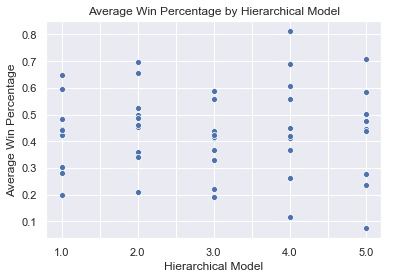

In [17]:
ax = sns.scatterplot(x="Hierarchical Model", y="Average Win Percentage", data=correct_df)
ax.set_title('Average Win Percentage by Hierarchical Model')
ax.set_xticklabels(np.linspace(0.5, 5, 10))

# code to modify xticks taken from here:
# https://stackoverflow.com/questions/38947115/how-to-decrease-the-density-of-x-ticks-in-seaborn
for ind, label in enumerate(ax.get_xticklabels()):
    if (ind + 1) % 2 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

In [164]:
np.median(means_rs_by_hm, axis=0)

array([0.4335    , 0.47483333, 0.41416667, 0.43533333, 0.46      ])

In [136]:
np.mean(means_rs_by_hm, axis=0)

array([0.4244    , 0.46853333, 0.39493333, 0.46936667, 0.4241    ])

In [137]:
np.var(means_rs_by_hm, axis=0)

array([0.01701457, 0.01869154, 0.01441706, 0.03767257, 0.03009231])

In [163]:
scipy.stats.sem(means_rs_by_hm, axis=0)

array([0.04347997, 0.04557233, 0.04002369, 0.06469807, 0.05782379])

# Analysis of Gammas from R

$x_{i,j,k}:=$# of wins for fake sample $j$ from model $k$ over real sample set $i$. 

\begin{align*}
x_{i,j,k}&\sim Poisson(\theta_{i,k})\\
\theta_{i,k}&=exp(\mu_{i}+\gamma_{k})
\end{align*}

In [14]:
gamma = pd.read_csv('./data/behavioral_gamma.csv').to_numpy()
mu = pd.read_csv('./data/behavioral_mu.csv').to_numpy()

In [15]:
gamma

array([[0.2169739 , 0.43744048, 0.17871252, 0.18277685, 0.68814521],
       [0.39425182, 0.41261686, 0.1663714 , 0.40758805, 0.38817829],
       [0.16652075, 0.35062616, 0.20861045, 0.70693925, 0.31603788],
       [0.24114753, 0.4038666 , 0.31959881, 0.58619276, 0.16444442],
       [0.54094345, 0.6842762 , 0.27869709, 1.03030851, 0.11887574],
       [0.45332724, 0.48935376, 0.43553943, 0.21172789, 0.09051479],
       [1.03782217, 1.22506139, 1.0184948 , 0.06174422, 1.37744971],
       [0.32397429, 0.50882229, 0.15452471, 0.57987598, 0.18627084],
       [0.33906973, 0.45303096, 0.14520696, 0.94610929, 0.20456656],
       [0.23055113, 0.28999952, 0.17579747, 0.57549801, 0.40360053]])

In [167]:
mu

array([[1.05745769],
       [0.94327328],
       [1.11109497],
       [0.67052277],
       [1.39890966],
       [0.13701602],
       [0.73954296],
       [0.51702225],
       [1.1139177 ],
       [1.09584356]])

In [159]:
index_to_model = {i:'Model {0}'.format(i+1) for i in range(num_h_models)}

places = {i:{j+1:0 for j in range(num_h_models)} for i in index_to_model.values()}

In [160]:

for i in range(gamma.shape[0]):
    
    ranked_indices = np.argsort(gamma[i,:])[::-1]
    placement = 1
    
    for next_best in ranked_indices:
        
        places[index_to_model[next_best]][placement]+=1
        placement += 1
       

In [161]:
places

{'Model 1': {1: 0, 2: 1, 3: 6, 4: 2, 5: 1},
 'Model 2': {1: 2, 2: 7, 3: 1, 4: 0, 5: 0},
 'Model 3': {1: 0, 2: 0, 3: 2, 4: 3, 5: 5},
 'Model 4': {1: 6, 2: 1, 3: 0, 4: 2, 5: 1},
 'Model 5': {1: 2, 2: 1, 3: 1, 4: 3, 5: 3}}

In [17]:
model_num = []
gamma_list = []
for j in range(gamma.shape[1]):
    for i in range(gamma.shape[0]):
        model_num.append(j+1)
        gamma_list.append(gamma[i,j])
analysis_df = pd.DataFrame(list(zip(model_num, gamma_list)), columns=['Model Number', 'Gamma'])

Text(0.5,1,'Gamma vs Model Number')

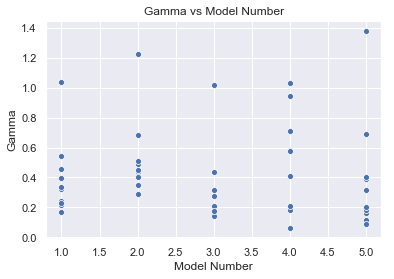

In [18]:
ax = sns.scatterplot(x="Model Number", y="Gamma", data=analysis_df)
ax.set_title('Gamma vs Model Number')

In [19]:
np.mean(gamma, axis=0)

array([0.3944582 , 0.52550942, 0.30815536, 0.52887608, 0.3938084 ])

In [20]:
np.median(gamma, axis=0)

array([0.33152201, 0.44523572, 0.19366149, 0.57768699, 0.26030222])

In [21]:
np.var(gamma, axis=0)

array([0.05807024, 0.06427656, 0.06362481, 0.09185749, 0.13594274])

In [22]:
scipy.stats.sem(gamma, axis=0)

array([0.0803259 , 0.08450941, 0.08407986, 0.10102667, 0.12290138])

In [146]:
means = list(np.mean(scores, axis=1))
samp_se_list = list(scipy.stats.sem(scores, axis=1))
var_list = list(np.var(scores, axis=1))

Where $\hat{p}$ is the probability of a dog getting shocked.

$X_{1it}$ and $X_{2it}$ are the number of times a dog has respectively been shocked and avoided being shocked in previous trials.

Model 1 
\begin{align*}
\hat{p}=\sigma(\beta_{1}+\beta_{2}X_{1it}+\beta_{3}X_{2it})
\end{align*}

Model 2 
\begin{align*}
\hat{p}=exp(\beta_{1}X_{1it}+\beta_{2}X_{2it})
\end{align*}

Model 3 
\begin{align*}
\hat{p}&=\sigma(\frac{\alpha}{t}+\gamma)&\text{$t$ is the trial number}
\end{align*}

Model 4 is the "switch." 

Model 5 
\begin{align*}
\hat{p}&=\frac{\alpha}{t}&\text{$t$ is the trial number}
\end{align*}


In [147]:
for mean, var, se, i in zip(means, var_list, samp_se_list, range(1,len(means)+1)):
    print('Model\t {0} \nMean\t {1}\nSE\t {2}\nVar\t {3}'.format(i, mean, se, var))
    print('------------------')


Model	 1 
Mean	 0.667177777777778
SE	 0.024067406051692514
Var	 0.016797960987654324
------------------
Model	 2 
Mean	 0.7062666666666666
SE	 0.021775332570521916
Var	 0.013750788148148148
------------------
Model	 3 
Mean	 0.5994777777777779
SE	 0.023751027044182103
Var	 0.01635922728395062
------------------
Model	 4 
Mean	 0.7566777777777778
SE	 0.03867475633216149
Var	 0.043376366543209886
------------------
Model	 5 
Mean	 0.5840888888888888
SE	 0.024412917321396405
Var	 0.017283725432098763
------------------


# Scaled Scores

In [159]:
scaled_scores = scores.copy()
scaler = MinMaxScaler()
scaled_scores = scaler.fit_transform(scaled_scores)
scaled_scores_df = pd.DataFrame(scaled_scores)
scaled_scores_df.to_csv('./data/behavioral_model_scaled_scores.csv', index=False, float_format='%.3f')

In [161]:
scaled_means = list(np.mean(scaled_scores, axis=1))
scaled_samp_se_list = list(scipy.stats.sem(scaled_scores, axis=1))
scaled_var_list = list(np.var(scaled_scores, axis=1))

In [162]:
for mean, var, se, i in zip(scaled_means, scaled_var_list, scaled_samp_se_list, range(1,len(scaled_means)+1)):
    print('Model\t {0} \nMean\t {1}\nSE\t {2}\nVar\t {3}'.format(i, mean, se, var))
    print('------------------')

Model	 1 
Mean	 0.514460045178651
SE	 0.05277298885496625
Var	 0.08076466222790538
------------------
Model	 2 
Mean	 0.6847650441536497
SE	 0.042408250528907565
Var	 0.05215533167475507
------------------
Model	 3 
Mean	 0.2499346024572722
SE	 0.04968043018215691
Var	 0.07157620914944088
------------------
Model	 4 
Mean	 0.8158547428141666
SE	 0.06065434855074908
Var	 0.10668954994535694
------------------
Model	 5 
Mean	 0.28147390527489147
SE	 0.06812138886255541
Var	 0.13457518499634114
------------------


In [27]:
a = np.zeros((5,1000))
b = np.zeros((5,1000))
np.dstack((a,b)).shape

(5, 1000, 2)

In [17]:
fake_samples_list[0].shape[0]

1000

In [18]:
num_real_samples

NameError: name 'num_real_samples' is not defined

In [22]:
np.sum(a, axis=1).shape

(5,)

In [32]:
np.reshape(a, (a.shape[1], a.shape[0])).shape

(1000, 5)

In [29]:
type(a)

numpy.ndarray

In [31]:
a.shape[0]

5